### Ben Goodwin

### NLP HW 7

### March 28th 2022

Question 1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

In [1]:
#Lets load some libraries from hw 5
#Libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
from requests import get
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import numpy  as np
import geopandas as gpd
import json
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from sklearn import cluster
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score

#### Full disclosure, I borrowed many of the ideas and general flows for k-means clustering on text data from this link
#### https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

##### I closely followed this example because I feel as though the plots that represent the most common words in the cluster really get at the core of this assignemnt.  


In [2]:
#Movies are the following 3:

#Dr.Strangelove or How I learned to stop worrying and love the bomb
#Anchorman
#Austin Powers

#Each of these fall into the comedy genere
#Each contains positive and negative reviews

#The file below is the actual review from IMDB from HW 5
dat = pd.read_csv("reviewList.csv")

#Examine the data
dat


,Review
0,I saw this film originally when I was about 12...
1,"I didn't quite understand all of the jokes, bu..."
2,As a film Dr. Strangelove was so well received...
3,"An impeccably-made slice of Cold War satire, K..."
4,Dr. Strangelove or: How I Learned to Stop Worr...
...,...
93,One of the great 90s spoof comedies. The vibe ...
94,"""Austin Powers: International Man of Mystery"" ..."
95,This is really a funny parody of the Bond movi...
96,"Mike Myers plays both Austin Powers, as groovy..."


In [3]:
#First off, lets define the corpus and generate a list
corpus = dat['Review'].tolist()

In [4]:
#This section is directly taken from https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
#These methods are quite useful for removing stopwords, and stemming

# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

In [5]:
#This section also heavily borrows from https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
#I have modifed this code to work with IMDB reviews 

#Define a function to process a corpus
def processCorpus(corpus, language):   
    #Pull english stopwords
    stopwords = nltk.corpus.stopwords.words(language)
    #Call stemmer
    param_stemmer = SnowballStemmer(language)
        
    #Iterate through the corpus    
    for document in corpus:
        index = corpus.index(document)
        
        #Tokenzie, apply stemming, and remove words
        listOfTokens = word_tokenize(corpus[index])
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, stopwords)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [6]:
language = 'english'
corpus = processCorpus(corpus, language)

In [8]:
#Lets start to process the reviews
#But again, lots of code here used from https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
final_df = tf_idf


In [14]:
#Here is a function to actualy run the k-means algorithm (https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb)
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

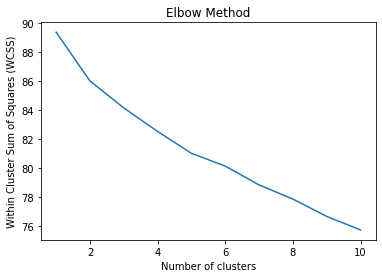

In [11]:

#Here is an example of the eblow method that is used to help determine the optimal number of clusters
#This example used from: https://www.datacamp.com/workspace/templates/recipe-python-k-means
wcss = []
for i in range(1, 11):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',                 # Initialization method for kmeans
                    max_iter = 300,                     # Maximum number of iterations 
                    n_init = 10,                        # Choose how often algorithm will run with different centroid 
                    random_state = 0)                   # Choose random state for reproducibility
    model.fit(final_df)                              
    wcss.append(model.inertia_)
    
# Show Elbow plot
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')                               # Set plot title
plt.xlabel('Number of clusters')                        # Set x axis name
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      # Set y axis name
plt.show()
#A takeaway here is that there isn't really a clearly defined eblow here

In [12]:
#These next few function are directly from: https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
#They are to assist in the plotting functionality 
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [20]:
# Running Kmeans
# Here is where we actually run kmeans
k = 5
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
#silhouette(kmeans_results, final_df, plot=True)

In [21]:
#The two functions below (again) are borrowed from https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb

# 

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

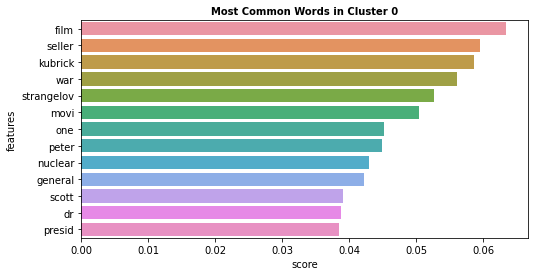

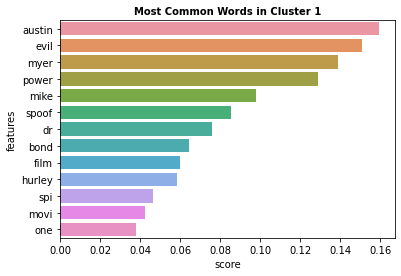

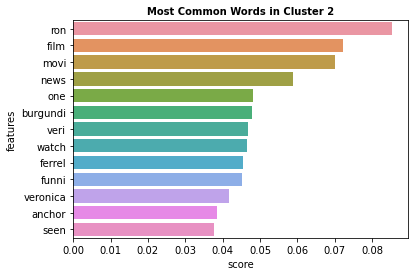

In [22]:

#Here we can define our number of clusters, here we set it to 3 
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

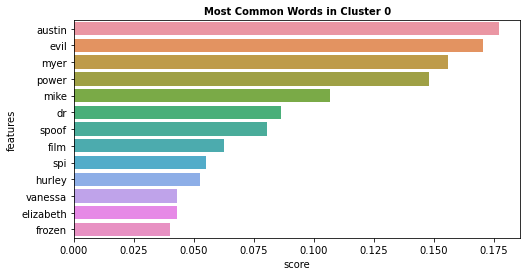

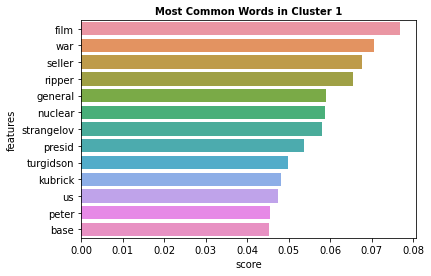

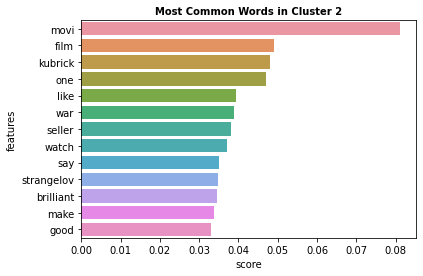

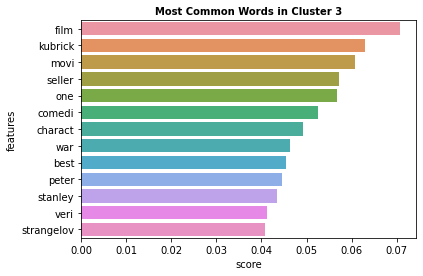

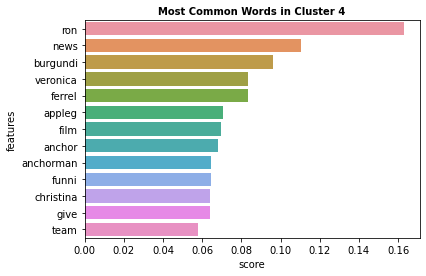

In [23]:

#Here we can define our number of clusters, this time we set it to 6
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

Question 2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact.

One of the main draws of using (https://nbviewer.org/github/LucasTurtle/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb) was the fact that the k-means clusters were very elegantly plotted in such a way that the most common words were shown as well as their score.  This seemed to be a unique approach to visualing k-means clustering.  Additionally, after making an elbow plot, we can see that determing an optimal number of clusters visually is quite difficult. 

When setting k for the first run of k-means, I chose an intuitive number of 3.  This is because I chose three different films, I would certainly hope that with the preprocessing that is done in the notebook again that the three movies would naturally cluster themselves.  Fortunately, it seems that for the most part, this task is accomplished.  
Dr.Strangelove has a difficult time with the most common word being "film", this could be because the reviews often speak very generally around the movie and often refer to it as a film. I think that reviewers are often referring to its cinematically qualities rather than overly mentioning characters or events.

3 clusters seems really ideal because there are 3 movies, and they do tend to cluster really well.  

If you have a working knowledge of the three of these movies you can tell that the clustering associated with each of these movies is spot on, if there is greater clustering we can see that Dr.Strangelove starts to drift into multiple clusters.  The semantic cluster of this movie may be more spread than the other two movies for the reasons I have described above.
The most frequently occuring non-stop word from Dr.Strangelove is "film", but followed by "Seller" (Peter Sellers) which is a word directly related to one of the stars of the movie.

The most frequently occuring non-stop word from Austin Power's is "Austin", this is very clearly identifiable as part of the title of the movie or the main character in the movie.  This shows that this cluster is pretty clearly centered semantically around this word "Austin" which seems like a great place to center semantically. Some of the other called out words are "Evil" "Myer".  This cluster is very clearly defined and shows that kmeans does quite well here.

Finally, the most frequently occuring non-stop word from Austin Power's is "Ron", this is also very clearly identifiable as the main character from this movie, "Ron Burgundy."  This is an excellent sign that the cluster for Anchorman is centered around "Ron" and means that k-means has done a good job identifying the cluster for this movie.  The other most frequently used words aren't quite as sharp as Austin Power's, but tend to do a good job and include words like "news" (The film is about a new station in San Diego) "veri" which is the stemmed version of Veronica (The antagonist or protagonist depending on your perspective).  




Question 3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why.

When working on the code for this assignemnt, it seems intuitive for me that when I performed k-means clustering, 3 clusters would be the ideal number of clusters since I selected reviews from three different movies.  I did my best to pick movies that were all considered comedies, but had a very different appeal and audience draw.  

For the first clustering run I selected three clusters, and the data seems to naturally cluster into three very seperable clusters.  Having intimate knowledge of each of these three movies was also useful as I could easily identify the top words associated with these three films.

For the second clustering run I selected 5 clusters. This time Dr.Strangelove seperated into 3 seperate clusters while Austin Powers and Anchorman: The legend of Ron Burgundy still contained themselves to one cluster each.  I feel that Dr.Strangelove seperated into different clusters because reviewers talk about this film in a different aspect as when compared to the other two films.  I think reviewers talk about its classic qualities and why they appreciate the film, whereas in Austin Powers and Anchorman the reviewers focus on the movie itself.